# Chatbot with Profile Schema 

## Review

We introduced the [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) as a way to save and retrieve long-term memories.

We built a simple chatbot that uses both `short-term (within-thread)` and `long-term (across-thread)` memory.

It saved long-term [semantic memory](https://langchain-ai.github.io/langgraph/concepts/memory/#semantic-memory) (facts about the user) ["in the hot path"](https://langchain-ai.github.io/langgraph/concepts/memory/#writing-memories), as the user is chatting with it.

## Goals

Our chatbot saved memories as a string. In practice, we often want memories to have a structure. 
 
For example, memories can be a [single, continuously updated schema]((https://langchain-ai.github.io/langgraph/concepts/memory/#profile)). 
 
In our case, we want this to be a single user profile.
 
We'll extend our chatbot to save semantic memories to a single [user profile](https://langchain-ai.github.io/langgraph/concepts/memory/#profile). 

We'll also introduce a library, [Trustcall](https://github.com/hinthornw/trustcall), to update this schema with new information. 

In [ ]:
 
%%capture --no-stderr
%pip install -U langchain_google_genai langgraph langchain_core

## Defining a user profile schema

Python has many different types for [structured data](https://python.langchain.com/docs/concepts/structured_outputs/#schema-definition), such as TypedDict, Dictionaries, JSON, and [Pydantic](https://docs.pydantic.dev/latest/). 

Let's start by using TypedDict to define a user profile schema.

In [1]:
from typing import TypedDict, List
from pydantic import BaseModel, Field
class UserProfile(BaseModel): 
    user_name: str 
    interests: List[str]  

In [2]:
 
user_profile: UserProfile = {
    "user_name": "arman",
    "interests": ["learning", "technology", "programming"]
}
user_profile

{'user_name': 'arman', 'interests': ['learning', 'technology', 'programming']}

We use the [put](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.put) method to save the TypedDict to the store.

In [5]:
import uuid
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()
user_id = "1"
namespace_for_memory = (user_id, "memory")
key = "user_profile"
value = user_profile
in_memory_store.put(namespace_for_memory, key, value)

We use [search](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search) to retrieve objects from the store by namespace.

In [6]:
print(in_memory_store.search(namespace_for_memory))

[Item(namespace=['1', 'memory'], key='user_profile', value={'user_name': 'arman', 'interests': ['learning', 'technology', 'programming']}, created_at='2025-02-17T13:49:50.129490+00:00', updated_at='2025-02-17T13:49:50.129490+00:00', score=None)]


In [7]:
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memory'], 'key': 'user_profile', 'value': {'user_name': 'arman', 'interests': ['learning', 'technology', 'programming']}, 'created_at': '2025-02-17T13:49:50.129490+00:00', 'updated_at': '2025-02-17T13:49:50.129490+00:00', 'score': None}


We can also use [get](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.get) to retrieve a specific object by namespace and key.

In [8]:
profile = in_memory_store.get(namespace_for_memory, "user_profile")
profile.value

{'user_name': 'arman', 'interests': ['learning', 'technology', 'programming']}

## Chatbot with profile schema

Now we know how to specify a schema for the memories and save it to the store.

Now, how do we actually *create* memories with this particular schema?

In our chatbot, we [want to create memories from a user chat](https://langchain-ai.github.io/langgraph/concepts/memory/#profile). 

This is where the concept of [structured outputs](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) is useful. 

LangChain's [chat model](https://python.langchain.com/docs/concepts/chat_models/) interface has a [`with_structured_output`](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) method to enforce structured output.

This is useful when we want to enforce that the output conforms to a schema, and it parses the output for us.

Let's pass the `UserProfile` schema we created to the `with_structured_output` method.

We can then invoke the chat model with a list of [messages](https://python.langchain.com/docs/concepts/messages/) and get a structured output that conforms to our schema.

In [10]:
from dotenv import load_dotenv
import os

load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
if not GEMINI_API_KEY:
    raise ValueError("GEMINI_API_KEY is not set in the .env file.")

print("API key loaded from .env file.")

API key loaded from .env file.


In [11]:
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field 

class UserProfile(BaseModel): 
    user_name: str 
    interests: List[str]  
    
from langchain_core.messages import HumanMessage  
model = ChatGoogleGenerativeAI(model='gemini-1.5-flash',api_key=GEMINI_API_KEY) 
model_with_structure = model.with_structured_output(UserProfile) 
structured_output = model_with_structure.invoke([HumanMessage("My name is Lance, I like to bike.")])
structured_output
 

UserProfile(user_name='Lance', interests=['bike'])

Now, let's use this with our chatbot.

This only requires minor changes to the `write_memory` function. 

We use `model_with_structure`, as defined above, to produce a profile that matches our schema. 

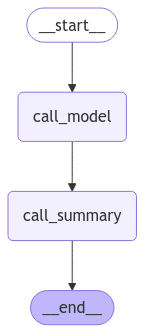

In [12]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
from pydantic import BaseModel, Field 

class UserProfile(BaseModel): 
    user_name: str 
    interests: List[str]  

MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""
def call_model(state:MessagesState,config:RunnableConfig,store:BaseStore):
  user_id = config["configurable"]["user_id"]
  namespace = ("memory", user_id) 
  existing_memory = store.get(namespace, 'user_memory') 
  if existing_memory and existing_memory.value:
     memory_dict = existing_memory.value
     formatted_memory = (
            f"Name: {memory_dict.user_name if memory_dict.user_name else 'Unknown'}\n"   
            f"Interests: {', '.join(memory_dict.interests)}" 
        )
  else:
    formatted_memory = None 
  sys_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)
 
  messages = [SystemMessage(content=sys_msg)] + state["messages"]

  resp = model.invoke(messages)
  return {"messages":resp}



CREATE_MEMORY_INSTRUCTION = """"You are collecting information about
the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""
def call_summary(state:MessagesState,config:RunnableConfig,store:BaseStore):
  user_id = config["configurable"]["user_id"]
  namespace = ("memory", user_id) 
  existing_memory = store.get(namespace, 'user_memory') 
  if existing_memory and existing_memory.value:
     memory_dict = existing_memory.value
     formatted_memory = (
            f"Name: {memory_dict.user_name if memory_dict.user_name else 'Unknown'}\n"  
            f"Interests: {', '.join(memory_dict.interests)}"  
        )
  else:
    formatted_memory = None 
  
  sys_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)
  messages = [SystemMessage(content=sys_msg) ]+ state["messages"]
  model_with_structure = model.with_structured_output(UserProfile)
  resp = model_with_structure.invoke(messages)  
  store.put(namespace, 'user_memory', resp)



graph = StateGraph(MessagesState)
graph.add_node('call_model',call_model)
graph.add_node('call_summary',call_summary)

graph.add_edge(START,'call_model') 
graph.add_edge('call_model','call_summary')
graph.add_edge('call_summary',END)

short_term_memory = MemorySaver()
long_term_memory = InMemoryStore()
compiled_graph = graph.compile(checkpointer=short_term_memory,store=long_term_memory) 

display(Image(compiled_graph.get_graph().draw_mermaid_png()))


In [13]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}} 
input_messages =  {"messages": [HumanMessage(content="Hi, my name is Arman and i like programming and solve math puzzles")]}
for chunk in compiled_graph.stream(input_messages, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

Hi, my name is Arman and i like programming and solve math puzzles
================================== Ai Message ==================================

Hello Arman!  It's nice to meet you.  I've noted that you like programming and solving math puzzles.  Is there anything specific you'd like to talk about today, perhaps a particular programming language you enjoy, or a type of math puzzle you find challenging/rewarding?


In [14]:
thread = {"configurable": {"thread_id": "1"}}
state = compiled_graph.get_state(thread).values
for m in state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Arman and i like programming and solve math puzzles
================================== Ai Message ==================================

Hello Arman!  It's nice to meet you.  I've noted that you like programming and solving math puzzles.  Is there anything specific you'd like to talk about today, perhaps a particular programming language you enjoy, or a type of math puzzle you find challenging/rewarding?


Let's check the memory in the store. 

We can see that the memory is a dictionary that matches our schema.

In [15]:
user_id = "1"
namespace = ("memory", user_id)
get_memory = long_term_memory.get(namespace,'user_memory')
if get_memory is not None:
    print(get_memory.value)   
else:
    print("No memory found for this user.")

user_name='Arman' interests=['programming', 'math puzzles']


In [16]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}} 
input_messages = [HumanMessage(content="Hi! What do you know about me?")] 
for chunk in compiled_graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! What do you know about me?
================================== Ai Message ==================================

Hi!  I know your name is Arman, and you're interested in programming and solving math puzzles.  Is there anything else you'd like to share?


In [17]:
config = {"configurable": {"thread_id": "2", "user_id": "1"}} 
input_messages = [HumanMessage(content="Hi! What do you know about me?")] 
for chunk in compiled_graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! What do you know about me?
================================== Ai Message ==================================

Hi Arman!  I know that you're interested in programming and math puzzles.  Is there anything else I should know about you?


## When can this fail?

[`with_structured_output`](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) is very useful, but what happens if we're working with a more complex schema? 

[Here's](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema) an example of a more complex schema, which we'll test below. 

This is a [Pydantic](https://docs.pydantic.dev/latest/) model that describes a user's preferences for communication and trust fall.

In [18]:
from typing import List, Optional

class OutputFormat(BaseModel):
    preference: str
    sentence_preference_revealed: str

class TelegramPreferences(BaseModel):
    preferred_encoding: Optional[List[OutputFormat]] = None
    favorite_telegram_operators: Optional[List[OutputFormat]] = None
    preferred_telegram_paper: Optional[List[OutputFormat]] = None

class MorseCode(BaseModel):
    preferred_key_type: Optional[List[OutputFormat]] = None
    favorite_morse_abbreviations: Optional[List[OutputFormat]] = None

class Semaphore(BaseModel):
    preferred_flag_color: Optional[List[OutputFormat]] = None
    semaphore_skill_level: Optional[List[OutputFormat]] = None

class TrustFallPreferences(BaseModel):
    preferred_fall_height: Optional[List[OutputFormat]] = None
    trust_level: Optional[List[OutputFormat]] = None
    preferred_catching_technique: Optional[List[OutputFormat]] = None

class CommunicationPreferences(BaseModel):
    telegram: TelegramPreferences
    morse_code: MorseCode
    semaphore: Semaphore

class UserPreferences(BaseModel):
    communication_preferences: CommunicationPreferences
    trust_fall_preferences: TrustFallPreferences

class TelegramAndTrustFallPreferences(BaseModel):
    pertinent_user_preferences: UserPreferences

Now, let's try extraction of this schema using the `with_structured_output` method.

In [ ]:
from pydantic import ValidationError

# Bind schema to model
model_with_structure = model.with_structured_output(TelegramAndTrustFallPreferences)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

# Invoke the model
try:
    model_with_structure.invoke(f"""Extract the preferences from the following conversation:
    <convo>
    {conversation}
    </convo>""")
except ValidationError as e:
    print(e)

In [ ]:
!pip install trustcall

## Trustcall for creating and updating profile schemas

As we can see, working with schemas can be tricky.

Complex schemas can be difficult to extract. 

In addition, updating even simple schemas can pose challenges.

Consider our above chatbot. 

We regenerated the profile schema *from scratch* each time we chose to save a new memory.

This is inefficient, potentially wasting model tokens if the schema contains a lot of information to re-generate each time.

Worse, we may loose information when regenerating the profile from scratch.

Addressing these problems is the motivation for [TrustCall](https://github.com/hinthornw/trustcall)!

This is an open-source library for updating JSON schemas developed by one [Will Fu-Hinthorn](https://github.com/hinthornw) on the LangChain team.

It's motivated by exactly these challenges while working on memory.

Let's first show simple usage of extraction with TrustCall on this list of [messages](https://python.langchain.com/docs/concepts/messages/).


We use `create_extractor`, passing in the model as well as our schema as a [tool](https://python.langchain.com/docs/concepts/tools/).

With TrustCall, can supply supply the schema in various ways. 

For example, we can pass a JSON object / Python dictionary or Pydantic model.

Under the hood, TrustCall uses [tool calling](https://python.langchain.com/docs/concepts/tool_calling/) to produce [structured output](https://python.langchain.com/docs/concepts/structured_outputs/) from an input list of [messages](https://python.langchain.com/docs/concepts/messages/).

To force Trustcall to produce [structured output](https://python.langchain.com/docs/concepts/structured_outputs/), we can include the schema name in the `tool_choice` argument.

We can invoke the extractor with  the above conversation.

In [20]:
from langchain_core.messages import HumanMessage, SystemMessage,AIMessage
from trustcall import create_extractor

conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="I really like biking around San Francisco.")]

class UserProfile(BaseModel):
    """User profile schema with typed fields"""
    user_name: str = Field(description="The user's preferred name")
    interests: List[str] = Field(description="A list of the user's interests")  

trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile"
)
 
system_msg = "Extract the user profile from the following conversation" 
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+conversation})  
print(result)               


Key 'title' is not supported in schema, ignoring


{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'UserProfile', 'arguments': '{"interests": ["biking", "San Francisco"], "user_name": "Lance"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-e2999f58-a236-4ab6-9427-781b9e9ac857-0', tool_calls=[{'name': 'UserProfile', 'args': {'interests': ['biking', 'San Francisco'], 'user_name': 'Lance'}, 'id': '264a6047-0b3e-4356-b7af-d15deef47297', 'type': 'tool_call'}], usage_metadata={'input_tokens': 65, 'output_tokens': 10, 'total_tokens': 75, 'input_token_details': {'cache_read': 0}})], 'responses': [UserProfile(user_name='Lance', interests=['biking', 'San Francisco'])], 'response_metadata': [{'id': '264a6047-0b3e-4356-b7af-d15deef47297'}], 'attempts': 1}


When we invoke the extractor, we get a few things:

* `messages`: The list of `AIMessages` that contain the tool calls. 
* `responses`: The resulting parsed tool calls that match our schema.
* `response_metadata`: Applicable if updating existing tool calls. It says which of the responses correspond to which of the existing objects.


In [21]:
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (264a6047-0b3e-4356-b7af-d15deef47297)
 Call ID: 264a6047-0b3e-4356-b7af-d15deef47297
  Args:
    interests: ['biking', 'San Francisco']
    user_name: Lance


In [22]:
schema = result["responses"]
schema

[UserProfile(user_name='Lance', interests=['biking', 'San Francisco'])]

In [23]:
schema[0].model_dump()

{'user_name': 'Lance', 'interests': ['biking', 'San Francisco']}

Let's see how we can use it to *update* the profile.

For updating, TrustCall takes a set of messages as well as the existing schema. 

The central idea is that it prompts the model to produce a [JSON Patch](https://jsonpatch.com/) to update only the relevant parts of the schema.

This is less error-prone than naively overwriting the entire schema.

It's also more efficient since the model only needs to generate the parts of the schema that have changed.

We can save the existing schema as a dict.

We can use `model_dump()` to serialize a Pydantic model instance into a dict. 

We pass it to the `"existing"` argument along with the schema name, `UserProfile`. 

In [24]:
 
updated_conversation = [HumanMessage(content="Hi, I'm Lance."), 
                        AIMessage(content="Nice to meet you, Lance."), 
                        HumanMessage(content="I really like biking around San Francisco."),
                        AIMessage(content="San Francisco is a great city! Where do you go after biking?"),
                        HumanMessage(content="I really like to go to a bakery after biking."),]
 
system_msg = f"""Update the memory (JSON doc) to incorporate new information from the following conversation"""
 
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+updated_conversation}, 
                                    {"existing": {"UserProfile": schema[0].model_dump()}})
print(result)

Key 'title' is not supported in schema, ignoring


{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'UserProfile', 'arguments': '{"interests": ["biking", "bakeries"], "user_name": "Lance"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-5b7618f8-954d-4500-9bed-680f06cf26dc-0', tool_calls=[{'name': 'UserProfile', 'args': {'interests': ['biking', 'bakeries'], 'user_name': 'Lance'}, 'id': '3f71d0e4-ab1f-4011-bd45-02917923c6cf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 97, 'output_tokens': 10, 'total_tokens': 107, 'input_token_details': {'cache_read': 0}})], 'responses': [UserProfile(user_name='Lance', interests=['biking', 'bakeries'])], 'response_metadata': [{'id': '3f71d0e4-ab1f-4011-bd45-02917923c6cf'}], 'attempts': 1}


In [25]:
updated_schema = result["responses"]
print(updated_schema)

[UserProfile(user_name='Lance', interests=['biking', 'bakeries'])]


In [26]:
updated_schema = result["responses"][0]
updated_schema 

UserProfile(user_name='Lance', interests=['biking', 'bakeries'])

 

Now, let's also test Trustcall on the [challenging schema](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema) that we saw earlier.

In [ ]:
from typing import List
from pydantic import BaseModel, Field

class OutputFormat(BaseModel):
    preference: str
    sentence_preference_revealed: str

class TelegramPreferences(BaseModel):
    preferred_encoding: List[OutputFormat] = Field(default_factory=list)
    favorite_telegram_operators: List[OutputFormat] = Field(default_factory=list)
    preferred_telegram_paper: List[OutputFormat] = Field(default_factory=list)

class MorseCode(BaseModel):
    preferred_key_type: List[OutputFormat] = Field(default_factory=list)
    favorite_morse_abbreviations: List[OutputFormat] = Field(default_factory=list)

class Semaphore(BaseModel):
    preferred_flag_color: List[OutputFormat] = Field(default_factory=list)
    semaphore_skill_level: List[OutputFormat] = Field(default_factory=list)

class TrustFallPreferences(BaseModel):
    preferred_fall_height: List[OutputFormat] = Field(default_factory=list)
    trust_level: List[OutputFormat] = Field(default_factory=list)
    preferred_catching_technique: List[OutputFormat] = Field(default_factory=list)

class CommunicationPreferences(BaseModel):
    telegram: TelegramPreferences
    morse_code: MorseCode
    semaphore: Semaphore

class UserPreferences(BaseModel):
    communication_preferences: CommunicationPreferences
    trust_fall_preferences: TrustFallPreferences

class TelegramAndTrustFallPreferences(BaseModel):
    pertinent_user_preferences: UserPreferences

bound = create_extractor(
    model,
    tools=[TelegramAndTrustFallPreferences],
    tool_choice="TelegramAndTrustFallPreferences",
)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

result = bound.invoke(
    f"""Extract the preferences from the following conversation:
<convo>
{conversation}
</convo>"""
)
 
result["responses"][0]

## Chatbot with profile schema updating

Now, let's bring Trustcall into our chatbot to create *and update* a memory profile.

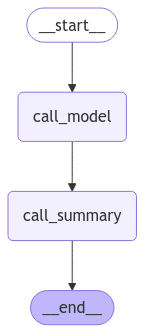

In [28]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
from pydantic import BaseModel, Field 
from typing import List

class UserProfile(BaseModel):
    """ Profile of a user """ 
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: List[str]  = Field(description="A list of the user's interests")

MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile", 
)
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation:"""

def call_model(state:MessagesState,config:RunnableConfig,store:BaseStore):
  user_id = config["configurable"]["user_id"]
  namespace = ("memory", user_id) 
  existing_memory = store.get(namespace, 'user_memory') 
  if existing_memory and existing_memory.value:
     memory_dict = existing_memory.value
     formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"      
        )
  else:
    formatted_memory = None 
  sys_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)
 
  messages = [SystemMessage(content=sys_msg)] + state["messages"]

  resp = model.invoke(messages)
  return {"messages":resp}



CREATE_MEMORY_INSTRUCTION = """"You are collecting information about
the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""
def call_summary(state:MessagesState,config:RunnableConfig,store:BaseStore):
  user_id = config["configurable"]["user_id"]
  namespace = ("memory", user_id) 
  existing_memory = store.get(namespace, 'user_memory') 
  existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None
  result = trustcall_extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)]+state["messages"], "existing": existing_profile})
  updated_profile = result["responses"][0].model_dump()
  
  store.put(namespace, 'user_memory', updated_profile)



graph = StateGraph(MessagesState)
graph.add_node('call_model',call_model)
graph.add_node('call_summary',call_summary)

graph.add_edge(START,'call_model') 
graph.add_edge('call_model','call_summary')
graph.add_edge('call_summary',END)

short_term_memory = MemorySaver()
long_term_memory = InMemoryStore()
compiled_graph = graph.compile(checkpointer=short_term_memory,store=long_term_memory) 

display(Image(compiled_graph.get_graph().draw_mermaid_png()))



In [29]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}} 
input_messages = [HumanMessage(content="Hi, my name is Arman, and I am from Sialkot. I am 23 years old.")] 
for chunk in compiled_graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

Hi, my name is Arman, and I am from Sialkot. I am 23 years old.


Key 'title' is not supported in schema, ignoring


================================== Ai Message ==================================

Hi Arman! It's nice to meet you.  I'll remember that you're 23 years old and from Sialkot.  Is there anything I can help you with today?


In [ ]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}} 
input_messages = [HumanMessage(content="I like programming")] 
for chunk in compiled_graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

In [32]:
user_id = "1"
namespace = ("memory", user_id)
existing_memory = long_term_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'user_name': 'Arman', 'user_location': 'Sialkot', 'interests': []},
 'created_at': '2025-02-17T13:51:54.317032+00:00',
 'updated_at': '2025-02-17T13:51:54.317032+00:00'}

In [ ]:

input_messages = [HumanMessage(content="I want to buy shoes and a dress.")] 
for chunk in compiled_graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

In [ ]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}} 
input_messages = [HumanMessage(content="I'm looking for black sneakers with a budget of $300 and a casual dress in white, with a budget of $400 and a waist size of 36 ")] 
for chunk in compiled_graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

In [ ]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}} 
input_messages = [HumanMessage(content="what do you know about me")] 
for chunk in compiled_graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

Continue the conversation in a new thread.

In [ ]:
config = {"configurable": {"thread_id": "2", "user_id": "1"}} 
input_messages = [HumanMessage(content="what do you know about me")] 
for chunk in compiled_graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

Trace:

https://smith.langchain.com/public/f45bdaf0-6963-4c19-8ec9-f4b7fe0f68ad/r

## Studio

![Screenshot 2024-10-30 at 11.26.31 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/6732d0437060f1754ea79908_Screenshot%202024-11-11%20at%207.48.53%E2%80%AFPM.png)